### Brown, Medina, Vaaga, Holla, and Raman - Core Model Simulation
Code written by Christopher E Vaaga (2022)

This computational model generates a biophysically realistic Purkinje cell, as originally published in Khaliq, Gouwens, and Raman (J Neurosci, 2003). To generate biophysically realistic spontaneous firing rates, spontaneous parallel fiber (n = 1000) and molecular layer interneuron (n = 5) synaptic conductances are added to a dendritic compartment, raising the spontaneous firing rate to ca. 75 Hz. 

The user has the ability to dynamically alter the model parameters, including various conditions to re-create the model data presented in the manuscript, or run additional models. Such modeling parameters are coded in module 4 of the model below. The specific conditions used to generate data presented in the manuscript are listed as comments in the relevant locations.

In [11]:
# =============================================================================
# Module 1: Import the necessary packages
# =============================================================================
import time
import os 
from neuron import h
from neuron.units import ms, mV
import neuron
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import pickle
import warnings
warnings.filterwarnings('ignore')


# !! Change directory to the correct directory on your local device
os.chdir(r'C:\Users\chris\OneDrive - Northwestern University\Documents\Neuron Simulations\Brown_Medina Model')

random.seed()
#load stdrun for hoc implementation 
h.load_file('stdrun.hoc')

#h.nrn_load_dll(r"C:\Users\Raman Lab\Desktop\Modeling - pkj synaptic inputs\nrnmech.dll")


1.0

In [12]:
# =============================================================================
# Module 2: Code to generate Purkinje cells with appropriate synaptic conductances
# synaptic conductances included in the cell body include INa (resurgent sodium current,
# 3 distinct IK channels, a BK channel, ICa, Ih, and leak channels. The dendrite includes 
# the same channels with the exception of the resurgent sodium current, and the BK channel. 
# =============================================================================


random.seed()

class Pkj:
    def __init__(self, gid):
        self.gid = gid #identifier to allow for creation of multiple cells with soma/dend
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        #create a soma appended to ballandstick cell
        self.soma = h.Section(name = 'soma', cell = self) 
        #create a dendrite section appended to ball and stick cell
        self.dend = h.Section(name = 'dend', cell = self) 
        self.all = [self.soma, self.dend]
        self.dend.connect(self.soma) #connect the dendrite to the soma   
        self.soma.L = self.soma.diam = 20 #creates a soma with an area of 500 um2
        self.dend.L = 300
        self.dend.diam = 2.2
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 35.4 #set the axial resistance of all sections to 100 Ohm * cm
            sec.cm = 1 #set the membrane capacitance to 1 microFarads / cm^2
        #Insert appropriate currents in soma
        self.soma.insert('kpkj2') #access current with     kpkj2._ref_ik_fast
        self.soma.insert('kpkj') #access current with      kpkj._ref_ik_fast
        self.soma.insert('naRsg') #access current with     naRsg._ref_ina
        self.soma.insert('lkpkj') 
        self.soma.insert('cadiff') 
        self.soma.insert('bkpkj') #access current with     bkpkj._ref_ik_bk
        self.soma.insert('cap') #access current with       cap._ref_ica
        self.soma.insert('hpkj') #not working...
        self.soma.insert('kpkjslow') #access current with  kpkjslow._ref_ik_slow
        self.soma.insert('extracellular')
        
        #Insert appropriate currents in dendrite
        self.dend.insert('kpkj2') #access current with      kpkj2._ref_ik_fast
        self.dend.insert('kpkj') #access current with       kpkj._ref_ik_fast
        self.dend.insert('lkpkj') 
        self.dend.insert('cadiff') 
        self.dend.insert('cap') #access current with        cap._ref_ica
        self.dend.insert('hpkj') 
        self.dend.insert('kpkjslow') #access current with   kpkjslow._ref_ik_slow
        
        #Set appropriate ENa and EK values
        self.soma.ena = 60
        self.soma.ek = -88
        
        #Increase the total sodium conductance from 0.015 S/cm^2 to 0.025 S/cm^2 to account for increased
        #sodium conductances in adults.
        self.soma.gbar_naRsg = 0.025

        self.dend.nseg = 31

        
        #Set up appropraite vectors to record spiking in Purkinje cells
        
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        
        
        #Set vector to record soma voltage
        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)
        
    def __repr__(self):
        return 'Pkj[{}]'.format(self.gid) #reformats name to allow for easy referencing

In [13]:
# =============================================================================
# Module 3: Set basic parameters of PF and MLI synaptic inputs.
# =============================================================================


#Spontaneous Inputs:
#Number of spontaneously active Parallel Fibers and MLI (sc)
n_pf = 1000
n_sc = 5


#MLI Inhibition - calculate conductance from G = I(Vm-Vrev), values of I from He et al., 2015
sc_I_avg = 200 #Current in pA
sc_I_std = 100 #StDev of current in pA

sc_g = (sc_I_avg * 10 **-12)/(70 * 10 **-3) * 10**6
sc_g_std = (sc_I_std * 10 **-12)/(70 * 10 **-3) * 10**6


sc = {'Conductance (mS)':sc_g * 1.3, #scale factor to account for clamp issues observed 
           'Conductance StDev (mS)':sc_g_std * 1.3, #scale factor to account for clamp issues observed
           'Spon Freq (Hz)':20, 
           'Spon Freq StDev (Hz)':10, 
           'Rise Time (ms)': 1.5 * 0.85, #Scale factor to account for dendritic filtering
           'Decay Time (ms)':8 * 0.85, #Scale factor to account for dendritic filtering
           'Reversal Potential (mV)': -70,
          }

#PF excitation - calculate conductance from G = I(Vm-Vrev), values of I from Isope and Barbour, 2002
pf_I_avg = 9 #Current in pA
pf_I_std = 7 #StDev of current in pA

pf_g = (pf_I_avg * 10 **-12)/(70 * 10 **-3) * 10**6
pf_g_std = (pf_I_avg * 10 **-12)/(70 * 10 **-3) * 10**6

pf = {'Conductance (mS)':pf_g , 
           'Conductance StDev (mS)':pf_g_std,
           'Spon Freq (Hz)':0.8, 
           'Spon Freq StDev (Hz)':0.5, 
           'Rise Time (ms)': 1 * 0.9, #Scale factor to accnount for dendritic filtering
           'Decay Time (ms)':14 * 0.9, #Scale factor to account for dendritic filtering
           'Reversal Potential (mV)': 0,
          }

syn_delay = 1.5



#Create a large parallel fiber amplitude distribution with PF amplitude values derived from Isope and Barbour, 2002.
#Because this distribution contains negative conductance values, these values are removed and the distribution is scaled
#to maintain the mean PF amplitude after removing negative events.

#create large distribution of conductances
pf_adjusted_dist = np.random.normal(pf['Conductance (mS)'], pf['Conductance StDev (mS)'],10000) 
#filter out any negative values
pf_adjusted_dist = list(filter(lambda x: (x > 0), pf_adjusted_dist)) 
#calculate the adjustment factor to restore mean to mean conductance from literature
pf_adj = pf['Conductance (mS)'] / np.mean(pf_adjusted_dist) 
#adjust filtered distribution to recenter values at mean conductance from literature 
pf_adjusted_dist = np.array(pf_adjusted_dist) * pf_adj 



#Create a large MLI amplitude distribution with amplitude values derived from He et al., 2015.
#Because this distribution contains negative conductance values, these values are removed and the distribution is scaled
#to maintain the mean MLI amplitude after removing negative events.

#create large distribution of conductances
mli_adjusted_dist = np.random.normal(sc['Conductance (mS)'], sc['Conductance StDev (mS)'], 10000)
#filter out any negative values
mli_adjusted_dist = list(filter(lambda x: (x > 0), mli_adjusted_dist)) 
#calculate the adjustment factor to restore mean to mean conductance from literature 
mli_adj = sc['Conductance (mS)'] / np.mean(mli_adjusted_dist) 
#adjust filtered distribution to recenter values at mean conductance from literature 
mli_adjusted_dist = np.array(mli_adjusted_dist) * mli_adj 

#Create a recovery probability distribution for reocvery from inhibition matching thetimecourse of inhibition from Golgi cells 
#Define the distribution for the recovery of Parallel fiber activity after GoC input.
#The tau of Golgi cell is biophysically constrained (values from Kanichay and Silver 2008)
golgi_tau = 7
recovery_times = np.linspace(0.001,20,5000)
recovery_probability = np.zeros(len(recovery_times))
for i in range(len(recovery_times)):
    recovery_probability[i] = 1 - math.exp((-recovery_times[i]/golgi_tau)) 
recovery_probability = np.divide(recovery_probability,sum(recovery_probability))


In [15]:
# =============================================================================
# Module 4: Setting the modeling parameters for a simulation run. The standard simulation run has 5000 trials. Users can
# select from a variety of distinct modeling conditions to generate simulations as performed in the manuscript. To 'turn on' a
# specific model condition, change the value from 0 to 1 and adjust the specific parameters of the model if desired.
# =============================================================================
#Set the number of trials to run the simulation
num_trials = 5000

#If not defined elsewhere, set the GPF and GMLI to 1:1
Gpf = 1
Gmli = 1

# Model Condition 1: INHIBITION ALONE -
# If this model is set to 1, it will run a simulation with a single inhibitory MLI event at time 0 in the model. The user has 
# option to change the conductance of the MLI input using the Gmli variable.

# In the published manuscript - this model was used to generate the data presented in figure 1 C, examining the effect of 
# alone on Pkj cell firing rates.
inhibition_alone = 0
if inhibition_alone == 1:
    Gmli = 1

# Model Condition 2: EXCITATION-INHIBITION COUPLING - WELL TIMED
# If this model is set to 1, the model will generate a single well-timed E-I sequence at time 0. The user has the option to 
# change the conductance of both inhibition and excitation by altering the GPF and GMLI variables. In this case, the randomly
# selected conductance (from the conductance distributions above) will be multiplied by the GPF or GMLI value as appropriate.

# In the published manuscript - this model was used to generate the data presented in figure 1 C, D, F with the following 
# conductances: (GPF:GMLI) 2:1, 4:1, 6:1, 4:2, 8:2, 12:2, 2:0.5, 3:0.5
well_timed = 1
if well_timed == 1:
    Gpf = 8
    Gmli = 1

# Model Condition 3: PARALLEL FIBER BURST - EXCITATION ALONE
# If this model is set to 1, the model will generate a burst of parallel fiber inputs, according to the values selected by the 
# user. 

# In the published manuscript - this model was used to generate the data presented in figure 1 G, with 15 additional parallel 
# fiber inputs, each with a conductance (GPF) of 1. Each additional parallel fiber fired at 50 +/- 5 sp/sec for 5 total spikes
# from each input.
burst = 0
if burst == 1: 
    burst_inputs = 15
    pf_burst_cond = 1
    burst_freq_avg = 50
    burst_freq_sem = 5
    burst_start = 150
    burst_num = 5
    Gpf = 1

# Model Condition 4: PARALLEL FIBER BURST - EXCITATION-INHIBITION COUPLING
# If this model is set to 1, the model will generate a burst of parallel fiber inputs, each of which will trigger an MLI input 
# at a synpatic delay of 1.5 ms. The PF and MLI properties can be adjusted by the user. 

# In the published manuscript - this model was used to generate the data presented in figure 1 G, with 15 additional parallel 
# fiber inputs, with a GPF:GMLI of either 1:1 or 4:1. Each additional parallel fiber fired at 50 +/- 5 sp/sec for 5 total spikes
# from each input. Each of these parallel fiber inputs also triggers an MLI input.
burst_coupled = 0
if burst_coupled == 1:
    burst_inputs = 15
    pf_burst_cond = 1
    mli_burst_cond = 1
    burst_freq_avg = 50
    burst_freq_sem = 5
    burst_num = 5
    burst_start = 150

# Model Condition 5: HARD-CODED PF FACILITATION EI SEQUENCE
# If this model is set to 1, the model will generate a burst of parallel fiber inputs, each of which will trigger an MLI input 
# at a synpatic delay of 1.5 ms. This model takes PF facilitation into account. 

# In the published manuscript - this model was used to generate the data presented in the supplementary Figure 1 B,C. 
# In this model, GPF starts at 1 and facilitates (across 5 successive stimuli at 50 Hz) to 4 GPF, consistent with synaptic data
# presented in Figure 1 F, G. 
facilitation = 0
if facilitation == 1:
    n_burst = 5
    burst_freq = 50
    timing_array = np.linspace(200,280, 5)
    pf_facilitation = [1, 2.25, 3, 3.5, 4]
    pf_difference = np.zeros(len(pf_facilitation))
    for i in range(1,len(pf_facilitation)):
        pf_difference[i] = pf_facilitation[i]-pf_facilitation[i-1]
    Gmli = 1
    
# Model Condition 6: WITHDRAWAL OF EXCITATION
# If this model is set to 1, the model will remove a set percentage of parallel fiber inputs at time 0, which will subsequently
# recover spiking according to the tau of Golgi cell IPSCs recorded in granule cells (Kanichay and Silver, 2008)

# In the published manuscript - this model was used to generate the data presented in the supplementary Figure 1 A. 
# In this model, 50% of parallel fiber inputs are removed at time 0 and then recover with the GoC time constant. 

withdrawal_of_exc = 0
if withdrawal_of_exc == 1:
        time_inhibition = 200
        pct_pf = 0.5
    
    
#If return trace = 1, the model output will include a random 10 current-clamp traces to examine.
return_trace = 1



In [16]:
# =============================================================================
# Module 5A: Defines the simulation for Purkinje cell models with delivery of well-timed synaptic conductances. 
# Includes optional modules for the following simulations: (1) Inhibition Alone, (2) Excitation-inhibition coupling - well timed,
# (3) Parallel fiber burst - excitation alone, (4) Parallel fiber burst - Excitation-inhibition coupling (5) Hard-Coded PF 
# facilitation - EI Sequence, and (6) Excitation-Inhibition coupling w/ additional PF inputs. The specific model run depends 
# on the parameter set in the above module. 
# =============================================================================

def pf_mli_simulation(return_trace = 0):
    from neuron import h
    h.load_file('stdrun.hoc')  #high level run control for the simulation

    #set up new raster for recording across all trials
    raster_pkj = []
    
    pkj = Pkj(1) 

#==============================================================================================================
# Module for creating variability in the spontaneous synaptic inputs (pf and MLI)
#
# For each spontaneously active input, we generate an Exp2Syn event which is randomly inserted along the dendrite to provide differential filtering
# The rise time and decay time are specified from literature values (PF: Isope and Barbour, 2002; MLI (SC): Vincent et al., 1992). Reversal potential is
# set to -70 mV for IPSCs and 0 mV for EPSCs. 
#
# The timing of the events (controlled by h.NetStim) - we generate a sufficient number of events such that events will continue for duration of the 
# model run time. The start time of each input is randomly distributed according to an exponential function with mean 50 ms to generate random start time.
# Each individual input is also assigned a spontaneous frequency which follows a normal distribution for parallel fibers (Chen et al., 2017) and stellate 
# cells (Badura et al., 2013). If the frequency selected is negative (by chance), it is corrected by assiging it to the mean spontaneous firing rate for each cell
# type. The frequency is then converted to an interspike interval which is passed to the NetStim object. Finally, the timing of each event is further randomized
# by using the NetStim noise function, which exponentially distributes the given fraction of inputs, centered at the mean spike interval. 
# All together, these parameters provide random spontaneously active inputs
#
# Finally, the amplitude of each individual input is determined by selecting a random conductance value from the above corrected conductance distributions. 
#==============================================================================================================

    #Create empty lists to store synapse, netstim and netcon objects for spontaneous parallel fiber inputs
    synapse_pf_spon = []
    stim_pf = []
    nc_pf = [] 

    #Create empty lists to store synapse, netstim and netcon objects for spontaneous mli inputs
    synapse_mli_spon = []
    stim_mli_spon = [] 
    nc_mli_spon = []

    #Generate spontaneous parallel fiber inputs
    for k in range(n_pf): 
        #Set up the synapse object with appropriate rise/decay time constants and reversal potential; insert at random position in dendrite
        synapse_pf_spon.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
        synapse_pf_spon[-1].tau1 = pf['Rise Time (ms)']
        synapse_pf_spon[-1].tau2 = pf['Decay Time (ms)']
        synapse_pf_spon[-1].e = pf['Reversal Potential (mV)']

        #Set up the NetStim object with exponentially distributed start times, each with a distinct spontaneous frequency 
        stim_pf.append(h.NetStim()) #append new netstim to netstim list
        stim_pf[-1].number = 200 #set number of mli events to generate (more than necessary for full length run)
        stim_pf[-1].start = np.random.exponential(50) #randomly distribute start times to increase "noise" in the system"
        freq_tmp = np.random.normal(pf['Spon Freq (Hz)'],pf['Spon Freq StDev (Hz)']) #Set each PF input to have a specific average firing rate (normally distributed)
        if freq_tmp < 0: freq_tmp = pf['Spon Freq (Hz)'] #correct for negative firing rates 
        stim_pf[-1].interval = 1000/freq_tmp
        stim_pf[-1].noise = 0.7 # set the noise of the pf timing, so that 70% of events are exponentially distributed (still with avg set by interval)

        #Use the NetCon object to connect each Exp2Syn object with each NetStim object; set amplitude (weight) via corrected conductance distribution
        nc_pf.append(h.NetCon(stim_pf[-1],synapse_pf_spon[-1])) 
        nc_pf[-1].weight[0] = np.random.choice(pf_adjusted_dist) 

    #Generate spontaneous mli inputs
    for j in range(n_sc): 
        #Set up the synapse object with appropriate rise/decay time constants and reversal potential; insert at random position in dendrite
        synapse_mli_spon.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
        synapse_mli_spon[-1].tau1 = sc['Rise Time (ms)']
        synapse_mli_spon[-1].tau2 = sc['Decay Time (ms)']
        synapse_mli_spon[-1].e = sc['Reversal Potential (mV)']

        #Set up the NetStim object with exponentially distributed start times, each with a distinct spontaneous frequency             
        stim_mli_spon.append(h.NetStim()) #append new netstim to netstim list
        stim_mli_spon[-1].number = 500 #set number of mli events to generate (more than necessary for full length run)
        stim_mli_spon[-1].start = np.random.exponential(50)  #randomly distribute start times to increase "noise" in the system"
        freq_tmp = np.random.normal(sc['Spon Freq (Hz)'],sc['Spon Freq StDev (Hz)'])
        stim_mli_spon[-1].interval = 1000/freq_tmp
        stim_mli_spon[-1].noise = 0.7 # set the noise of the mli timing, so that 70% of events are exponentially distributed (still with avg set by interval)

        #Use the NetCon object to connect each Exp2Syn object with each NetStim object; set amplitude (weight) via corrected conductance distribution
        nc_mli_spon.append(h.NetCon(stim_mli_spon[-1],synapse_mli_spon[-1]))  
        nc_mli_spon[-1].weight[0] = np.random.choice(mli_adjusted_dist) 


#==============================================================================================================
# Module for inserting well-timed synaptic events (pf, mli or both)
#
# Well timed events are similarly generated using the Exp2Syn event and random insertion along the dendrite to provide differential filtering
# The rise time and decay time are specified from literature values (PF: Isope and Barbour, 2002; MLI (SC): Vincent et al., 1992). Reversal potential is
# set to -70 mV for IPSCs and 0 mV for EPSCs. 
#
# A single parallel fiber event is generated by h.NetStim at a specified time (allowing for model to reach steady state spontaneous firing rate (200 ms)).
# MLI inputs are delayed an additional 1.5 ms to account for synaptic delay between pf and mli (empirically measured in accompanying manuscript)
#
# Finally, the amplitude of each individual input is determined by selecting a random conductance value from the above corrected conductance distributions. 
# To account for different levels of pre-potentiation, the unitary conductance selected is then multiplied by a scale factor depending on the model being run. 
# For example, to test the effect of 5x parallel fiber potentiation triggering a single MLI (SC), the pf_scale_factor = 5 and mli_scale_factor = 1
#==============================================================================================================

    if inhibition_alone == 1:
        #Synapse object for well-timed parallel fiber input, randomly inserted along Purkinje cell dendrite
        mli_synapse_welltimed = h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000))
        mli_synapse_welltimed.tau1 = sc['Rise Time (ms)']
        mli_synapse_welltimed.tau2 = sc['Decay Time (ms)']
        mli_synapse_welltimed.e = sc['Reversal Potential (mV)']

        #Parallel fiber netstim object to deliver single parallel fiber input at 200 ms (enough to allow model to reach steady state firing rate)
        mli_ns_welltimed = h.NetStim()
        mli_ns_welltimed.number = 1
        mli_ns_welltimed.start = 200 

        #Ranodmly select conductance from above corrected pf conductance distrubiton, multiple the unitary conductance by pf_scale_factor.
        #pf_scale_factor varies across model runs to account for different levels of parallel fiber pre-potentiation. 
        mli_nc_welltimed = h.NetCon(mli_ns_welltimed,mli_synapse_welltimed)
        mli_nc_welltimed.weight[0] = np.random.choice(mli_adjusted_dist) * Gmli



    if well_timed == 1:
        #Synapse object for well-timed parallel fiber input, randomly inserted along Purkinje cell dendrite
        pf_synapse_welltimed = h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000))
        pf_synapse_welltimed.tau1 = pf['Rise Time (ms)']
        pf_synapse_welltimed.tau2 = pf['Decay Time (ms)']
        pf_synapse_welltimed.e = pf['Reversal Potential (mV)']

        #Parallel fiber netstim object to deliver single parallel fiber input at 200 ms (enough to allow model to reach steady state firing rate)
        pf_ns_welltimed = h.NetStim()
        pf_ns_welltimed.number = 1
        pf_ns_welltimed.start = 200 

        #Ranodmly select conductance from above corrected pf conductance distrubiton, multiple the unitary conductance by pf_scale_factor.
        #pf_scale_factor varies across model runs to account for different levels of parallel fiber pre-potentiation. 
        pf_nc_welltimed = h.NetCon(pf_ns_welltimed,pf_synapse_welltimed)
        pf_nc_welltimed.weight[0] = np.random.choice(pf_adjusted_dist) * Gpf

        #Synapse object for well-timed parallel fiber input, randomly inserted along Purkinje cell dendrite
        mli_synapse_welltimed = h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000))
        mli_synapse_welltimed.tau1 = sc['Rise Time (ms)']
        mli_synapse_welltimed.tau2 = sc['Decay Time (ms)']
        mli_synapse_welltimed.e = sc['Reversal Potential (mV)']

        #Parallel fiber netstim object to deliver single parallel fiber input at 200 ms (enough to allow model to reach steady state firing rate)
        mli_ns_welltimed = h.NetStim()
        mli_ns_welltimed.number = 1
        mli_ns_welltimed.start = 200 + syn_delay

        #Ranodmly select conductance from above corrected pf conductance distrubiton, multiple the unitary conductance by pf_scale_factor.
        #pf_scale_factor varies across model runs to account for different levels of parallel fiber pre-potentiation. 
        mli_nc_welltimed = h.NetCon(mli_ns_welltimed,mli_synapse_welltimed)
        mli_nc_welltimed.weight[0] = np.random.choice(mli_adjusted_dist) * Gmli



    if burst == 1:
        synapse_pf_burst = []
        stim_pf_burst = [] 
        nc_pf_burst = []

        for r in range(burst_inputs): 
            #Set up the synapse object with appropriate rise/decay time constants and reversal potential; insert at random position in dendrite
            synapse_pf_burst.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
            synapse_pf_burst[-1].tau1 = pf['Rise Time (ms)']
            synapse_pf_burst[-1].tau2 = pf['Decay Time (ms)']
            synapse_pf_burst[-1].e = pf['Reversal Potential (mV)']

            #Set up the NetStim object with exponentially distributed start times, each with a distinct spontaneous frequency 
            stim_pf_burst.append(h.NetStim()) #append new netstim to netstim list
            stim_pf_burst[-1].number = burst_num #set number of events to generate (more than necessary for full length run)
            stim_pf_burst[-1].start = np.random.exponential(20)+burst_start #randomly distribute start times to increase "noise" in the system"
            freq_tmp = np.random.normal(burst_freq_avg,burst_freq_sem) #Set each PF input to have a specific average firing rate (normally distributed)
            if freq_tmp < 0: freq_tmp = burst_freq_avg #correct for negative firing rates 
            stim_pf_burst[-1].interval = 1000/freq_tmp
            stim_pf_burst[-1].noise = 0.7 # set the noise of the pf timing, so that 70% of events are exponentially distributed (still with avg set by interval)

            #Use the NetCon object to connect each Exp2Syn object with each NetStim object; set amplitude (weight) via corrected conductance distribution
            nc_pf_burst.append(h.NetCon(stim_pf_burst[-1],synapse_pf_burst[-1])) 
            nc_pf_burst[-1].weight[0] = np.random.choice(pf_adjusted_dist) * pf_burst_cond



    if burst_coupled == 1: 
        synapse_pf_burst = []
        stim_pf_burst = [] 
        nc_pf_burst = []

        synapse_mli_burst = []
        stim_mli_burst = [] 
        nc_mli_burst = []

        start_array = np.random.exponential(20, burst_inputs)+burst_start
        freq_array = np.random.normal(burst_freq_avg, burst_freq_sem, burst_inputs) 
        freq_array[freq_array<15] = burst_freq_avg

        for r in range(burst_inputs): 
            #Set up the synapse object with appropriate rise/decay time constants and reversal potential; insert at random position in dendrite
            synapse_pf_burst.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
            synapse_pf_burst[-1].tau1 = pf['Rise Time (ms)']
            synapse_pf_burst[-1].tau2 = pf['Decay Time (ms)']
            synapse_pf_burst[-1].e = pf['Reversal Potential (mV)']

            #Set up the NetStim object with exponentially distributed start times, each with a distinct spontaneous frequency 
            stim_pf_burst.append(h.NetStim()) #append new netstim to netstim list
            stim_pf_burst[-1].number = burst_num #set number of events to generate (more than necessary for full length run)
            stim_pf_burst[-1].start = start_array[r] #randomly distribute start times to increase "noise" in the system"
            stim_pf_burst[-1].interval = 1000/freq_array[r]

            #Use the NetCon object to connect each Exp2Syn object with each NetStim object; set amplitude (weight) via corrected conductance distribution
            nc_pf_burst.append(h.NetCon(stim_pf_burst[-1],synapse_pf_burst[-1])) 
            nc_pf_burst[-1].weight[0] = np.random.choice(pf_adjusted_dist) * pf_burst_cond


            #Set up the synapse object with appropriate rise/decay time constants and reversal potential; insert at random position in dendrite
            synapse_mli_burst.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
            synapse_mli_burst[-1].tau1 = sc['Rise Time (ms)']
            synapse_mli_burst[-1].tau2 = sc['Decay Time (ms)']
            synapse_mli_burst[-1].e = sc['Reversal Potential (mV)']

            #Set up the NetStim object with exponentially distributed start times, each with a distinct spontaneous frequency 
            stim_mli_burst.append(h.NetStim()) #append new netstim to netstim list
            stim_mli_burst[-1].number = burst_num #set number of events to generate (more than necessary for full length run)
            stim_mli_burst[-1].start = start_array[r] + syn_delay #randomly distribute start times to increase "noise" in the system"
            stim_mli_burst[-1].interval = 1000/freq_array[r]

            #Use the NetCon object to connect each Exp2Syn object with each NetStim object; set amplitude (weight) via corrected conductance distribution
            nc_mli_burst.append(h.NetCon(stim_mli_burst[-1],synapse_mli_burst[-1])) 
            nc_mli_burst[-1].weight[0] = np.random.choice(mli_adjusted_dist) * mli_burst_cond



    if facilitation == 1:
        synapse_pf_burst = []
        stim_pf_burst = [] 
        nc_pf_burst = []


        for y in range(n_burst):
            #Set up the synapse object with appropriate rise/decay time constants and reversal potential; insert at random position in dendrite
            synapse_pf_burst.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
            synapse_pf_burst[-1].tau1 = pf['Rise Time (ms)']
            synapse_pf_burst[-1].tau2 = pf['Decay Time (ms)']
            synapse_pf_burst[-1].e = pf['Reversal Potential (mV)']

            #Set up the NetStim object with exponentially distributed start times, each with a distinct spontaneous frequency 
            stim_pf_burst.append(h.NetStim()) #append new netstim to netstim list
            stim_pf_burst[-1].number = n_burst - y #set number of events to generate (more than necessary for full length run)
            stim_pf_burst[-1].start = timing_array[y] #randomly distribute start times to increase "noise" in the system"
            stim_pf_burst[-1].interval = 1000/burst_freq

            #Use the NetCon object to connect each Exp2Syn object with each NetStim object; set amplitude (weight) via corrected conductance distribution
            nc_pf_burst.append(h.NetCon(stim_pf_burst[-1],synapse_pf_burst[-1])) 
            pf_amplitudes = np.random.choice(pf_adjusted_dist, 5)
            nc_pf_burst[-1].weight[0] = pf_amplitudes[y] + (pf_amplitudes[y] * pf_difference[y])


        #Set up the synapse object with appropriate rise/decay time constants and reversal potential; insert at random position in dendrite
        synapse_mli_burst = h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000))
        synapse_mli_burst.tau1 = sc['Rise Time (ms)']
        synapse_mli_burst.tau2 = sc['Decay Time (ms)']
        synapse_mli_burst.e = sc['Reversal Potential (mV)']

        #Set up the NetStim object with exponentially distributed start times, each with a distinct spontaneous frequency 
        stim_mli_burst = h.NetStim() #append new netstim to netstim list
        stim_mli_burst.number = n_burst #set number of events to generate (more than necessary for full length run)
        stim_mli_burst.start = timing_array[0] + syn_delay #randomly distribute start times to increase "noise" in the system"
        stim_mli_burst.interval = 1000/burst_freq

        #Use the NetCon object to connect each Exp2Syn object with each NetStim object; set amplitude (weight) via corrected conductance distribution
        nc_mli_burst = h.NetCon(stim_mli_burst,synapse_mli_burst)
        nc_mli_burst.weight[0] = np.random.choice(mli_adjusted_dist) 



#==============================================================================================================
# Module for collecting spike output of Purkinje Cells
#
# To record the spike time of the modeled Purkinje cell, we generate an empty NEURON vector and then use a netcon event to detect when the amplitude
# of the somatic voltage reaches a threshold value of -10 mV (some APs do not fully overshoot 0 depending on synaptic conductances, therefore a 
# threshold of -10 mV was selected). The detected events are then recorded in the NEURON vector which is ultimately converted into a panda series
# Each trial run is then appended and ultimately concatenated and returned from the function. In this model configuration, firing rates of each individual trial 
# are not separately recorded, but rather concatenated to a single vector for histogram analysis (see _raster simulation files for generation of spike rasters)
#==============================================================================================================

    pkj_raster = h.Vector() #Create a raster vector
    nc_target_pkj = h.NetCon(pkj.soma(0.5)._ref_v, None, sec = pkj.soma) #Netcon with empty target to detect when events are generated in soma
    nc_target_pkj.threshold = -10 #Set threshold for event detection
    nc_target_pkj.record(pkj_raster) #Records the timing events into pkj_raster vector

    t = h.Vector().record(h._ref_t)

    h.finitialize() #initialize simulation
    h.continuerun(300*ms) #run simulation for 300 ms 

    df_pkj = pd.Series(pkj_raster) #Make a dataframe of pkj_raster

    raster_pkj.append(df_pkj)
    raster_pkj = np.concatenate(raster_pkj)

    if return_trace == 1:
        mem_pot = pkj.soma_v
        return raster_pkj, np.array(t), mem_pot
    else:
        return raster_pkj


In [17]:
# =============================================================================
# Module 5B: Defines the simulation for Purkinje cell models with withdrawal of excitation. 
# Includes the module for withdrawal of excitation model alone. The specific model run depends 
# on the parameter set in the above module. The removal of excitation to X% of PF inputs is achieved with a negative netcon
# weight which disables those inputs from continuing to provide inputs. The same fraction then recovers to spiking with an 
# exponential timecourse that matches the tau of GoC inhibition in granule cells. 
# =============================================================================

def GoC_simulation(pct_pf):
    
    raster_pkj = []  
    for i in range(num_trials):
        from neuron import h
        from neuron.units import ms, mV
        from Create_PkjCell import Pkj
        h.load_file('stdrun.hoc')  #high level run control for the simulation


        pkj = Pkj(1)
                
        nc_pf = [] #set up list for pf netcon objects
        stim_pf = [] #set up list for pf netstim objects
    
        nc_mli_spon = [] #set up list for mli NetCon objects
        stim_mli_spon = [] #set up list for mli NetStim objects
        
        synapse_pf_spon = []
        synapse_mli_spon = []
        synapse_mli = []
        
        synapse_pf_spon_2 = []
        stim_pf_2 = []
        synapse_pf_spon_2 = []
        
        stop_ns_pf = []
        stop_nc_pf = []
        nc_pf_2 = []
        
        synapse_pf_spon_3 = []
        stim_pf_3 = []
        synapse_pf_spon_3 = []
        nc_pf_3 = []
        
#==============================================================================================================
# Module for creating variability in the spontaneous synaptic inputs (pf and MLI)
#
# For each spontaneously active input, we generate an Exp2Syn event which is randomly inserted along the dendrite to provide differential filtering
# The rise time and decay time are specified from literature values (PF: Isope and Barbour, 2002; MLI (SC): Vincent et al., 1992). Reversal potential is
# set to -70 mV for IPSCs and 0 mV for EPSCs. 
#
# The timing of the events (controlled by h.NetStim) - we generate a sufficient number of events such that events will continue for duration of the 
# model run time. The start time of each input is randomly distributed according to an exponential function with mean 50 ms to generate random start time.
# Each individual input is also assigned a spontaneous frequency which follows a normal distribution for parallel fibers (Chen et al., 2017) and stellate 
# cells (Badura et al., 2013). If the frequency selected is negative (by chance), it is corrected by assiging it to the mean spontaneous firing rate for each cell
# type. The frequency is then converted to an interspike interval which is passed to the NetStim object. Finally, the timing of each event is further randomized
# by using the NetStim noise function, which exponentially distributes the given fraction of inputs, centered at the mean spike interval. 
# All together, these parameters provide random spontaneously active inputs
#
# Finally, the amplitude of each individual input is determined by selecting a random conductance value from the above corrected conductance distributions. 
#==============================================================================================================
      
        #For loop to create n of spon pf inputs that will continue firing throughout model 
        for k in range(int(n_pf*(1-pct_pf))): #For loop to create n of spon pf inputs
            #Set parallel fiber synapse properties:
            synapse_pf_spon.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
            synapse_pf_spon[-1].tau1 = pf['Rise Time (ms)']
            synapse_pf_spon[-1].tau2 = pf['Decay Time (ms)']
            synapse_pf_spon[-1].e = pf['Reversal Potential (mV)']
    
            #Set parallel fiber NetStim objects:
            stim_pf.append(h.NetStim()) #append new netstim to netstim list
            stim_pf[-1].number = 15 #set number of pf events to generate
            stim_pf[-1].start = np.random.exponential(50) #randomly distribute start times to increase "noise" in the system"
            freq_tmp = np.random.normal(pf['Spon Freq (Hz)'],pf['Spon Freq StDev (Hz)']) #Set each PF input to have a specific average firing rate (normally distributed)
            if freq_tmp < 0: freq_tmp = pf['Spon Freq (Hz)'] #Correct for negative events
            stim_pf[-1].interval = 1000/freq_tmp
            stim_pf[-1].noise = 0.7 # set the noise of the pf timing, so that 70% of events are exponentially distributed (still with avg set by interval)
    
            #Set parallel fiber NetCon objects:
            nc_pf.append(h.NetCon(stim_pf[-1],synapse_pf_spon[-1])) #append NetStim[i] to syn_mli mechanism defined in pkj class
            pf_conductance = np.random.normal(pf['Conductance (mS)'],pf['Conductance StDev (mS)']) 
            if pf_conductance < 0: pf_conductance = pf['Conductance (mS)'] #Correct for events that are outward - if event chosen is negative set to the mean
            nc_pf[-1].weight[0] = np.random.choice(pf_adjusted_dist)
    
        #For loop to create n of spon mli inputs
        for j in range(5): 
            synapse_mli_spon.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
            synapse_mli_spon[-1].tau1 = sc['Rise Time (ms)']
            synapse_mli_spon[-1].tau2 = sc['Decay Time (ms)']
            synapse_mli_spon[-1].e = sc['Reversal Potential (mV)']
            
            stim_mli_spon.append(h.NetStim()) #append new netstim to netstim list
            stim_mli_spon[-1].number = 50 #set number of mli events to generate
            stim_mli_spon[-1].start = np.random.exponential(50)  #randomly distribute start times to increase "noise" in the system"
            frq_tmp = np.random.normal(sc['Spon Freq (Hz)'],sc['Spon Freq StDev (Hz)'])
            if freq_tmp < 0: freq_tmp = sc['Spon Freq (Hz)'] 
            stim_mli_spon[-1].interval = 1000/frq_tmp
            stim_mli_spon[-1].noise = 0.7 # set the noise of the pf timing, so that 70% of events are exponentially distributed (still with avg set by interval)
    
            nc_mli_spon.append(h.NetCon(stim_mli_spon[-1],synapse_mli_spon[-1]))  #append NetStim[i] to syn_pf mechanism defined in pkj class
            nc_mli_spon[-1].weight[0] = np.random.choice(mli_adjusted_dist) #set synaptic weight by dividing amplitude by netcon scale factor
    
        
        
        #Subest of PF to remove with "golgi cell" input, set by user in above module (Module 4)
        for j in range(int(n_pf * pct_pf)): #For loop to create n of spon pf inputs
            #Set parallel fiber synapse properties:
            synapse_pf_spon_2.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
            synapse_pf_spon_2[-1].tau1 = pf['Rise Time (ms)']
            synapse_pf_spon_2[-1].tau2 = pf['Decay Time (ms)']
            synapse_pf_spon_2[-1].e = pf['Reversal Potential (mV)']
            
            #Set parallel fiber NetStim objects:
            stim_pf_2.append(h.NetStim()) #append new netstim to netstim list
            stim_pf_2[-1].number = 15 #set number of pf events to generate
            stim_pf_2[-1].start = np.random.exponential(50) #randomly distribute start times to increase "noise" in the system"
            freq_tmp = np.random.normal(pf['Spon Freq (Hz)'],pf['Spon Freq StDev (Hz)']) #Set each PF input to have a specific average firing rate (normally distributed)
            if freq_tmp < 0: freq_tmp = pf['Spon Freq (Hz)'] #Correct for negative events
            stim_pf_2[-1].interval = 1000/freq_tmp
            stim_pf_2[-1].noise = 0.7 # set the noise of the pf timing, so that 70% of events are exponentially distributed (still with avg set by interval)
    
            #Set parallel fiber NetCon objects:
            nc_pf_2.append(h.NetCon(stim_pf_2[-1],synapse_pf_spon_2[-1])) #append NetStim[i] to syn_mli mechanism defined in pkj clas
            nc_pf_2[-1].weight[0] = np.random.choice(pf_adjusted_dist) #set synaptic weight by dividing amplitude by netcon scale factor
            
            #Send negative weight netCon event to "stop" pf inputs - equivalent to GoC input 
            stop_ns_pf.append(h.NetStim())
            stop_ns_pf[-1].number = 1
            stop_ns_pf[-1].start = time_inhibition
    
            stop_nc_pf.append(h.NetCon(stop_ns_pf[-1],stim_pf_2[-1]))
            stop_nc_pf[-1].weight[0] = -0.1
                    
            #Recovery of pf spiking via exponential distribution matching GoC kinetics    
            synapse_pf_spon_3.append(h.Exp2Syn(pkj.dend(np.random.randint(0,1000)/1000)))
            synapse_pf_spon_3[-1].tau1 = pf['Rise Time (ms)']
            synapse_pf_spon_3[-1].tau2 = pf['Decay Time (ms)']
            synapse_pf_spon_3[-1].e = pf['Reversal Potential (mV)']
            
            stim_pf_3.append(h.NetStim()) #append new netstim to netstim list
            stim_pf_3[-1].number = 15 #set number of pf events to generate        
            stim_pf_3[-1].start = time_inhibition + np.random.choice(recovery_times,p=recovery_probability)
            freq_tmp = np.random.normal(pf['Spon Freq (Hz)'],pf['Spon Freq StDev (Hz)']) #Set each PF input to have a specific average firing rate (normally distributed)
            if freq_tmp < 0: freq_tmp = pf['Spon Freq (Hz)'] #Correct for negative events
            stim_pf_3[-1].interval = 1000/freq_tmp
            stim_pf_3[-1].noise = 0.7 # set the noise of the pf timing, so that 70% of events are exponentially distributed (still with avg set by interval)
    
            nc_pf_3.append(h.NetCon(stim_pf_3[-1],synapse_pf_spon_3[-1])) #append NetStim[i] to syn_mli mechanism defined in pkj class
            nc_pf_3[-1].weight[0] = np.random.choice(pf_adjusted_dist) #set synaptic weight by dividing amplitude by netcon scale factor
    
        
    

        #Next - work to do some analysis (inst firing rate, rasters)
        pkj_raster = h.Vector() #Create a raster vector
        nc_target_pkj = h.NetCon(pkj.soma(0.5)._ref_v, None, sec = pkj.soma) #Netcon with empty target to detect when events are generated in soma
        nc_target_pkj.threshold = -10 #Set threshold for event detection
        nc_target_pkj.record(pkj_raster) #Records the timing events into pkj_raster vector

        t = h.Vector().record(h._ref_t)
        
        h.finitialize() #initialize simulation
        h.continuerun(300*ms) #run simulation for 300 ms 

        df_pkj = pd.Series(pkj_raster) #Make a dataframe of pkj_raster
        
        raster_pkj.append(df_pkj)
        raster_pkj = np.concatenate(raster_pkj)
        
        if return_trace == 1:
            mem_pot = pkj.soma_v
            return raster_pkj, np.array(t), mem_pot
        else:
            return raster_pkj


In [ ]:
 #For loop to run the MLI Inhibition model simulation n times
    
if withdrawal_of_exc == 0:    
    if return_trace == 1: 
        t = np.zeros((num_trials,12001)) #12001 is length of vector for 300 ms trial run
        mem_pot = np.zeros((num_trials, 12001))
        for i in range(1,num_trials):
            df_pkj, t[i], mem_pot[i] = pf_mli_simulation(return_trace = 1) #Run the simulation, passing in the necessary variables and writing spike times to df_pkj
            if i ==1:
                spike_times_all = np.array(df_pkj)
                position_raster = np.zeros(len(df_pkj))+i
            else:
                spike_times_all = np.append(spike_times_all, df_pkj)
                position_raster = np.append(position_raster, np.zeros(len(df_pkj))+i)

    else: 
        df_pkj = pf_mli_simulation(return_trace = 0)
        if i ==1:
            spike_times_all = np.array(df_pkj)
            position_raster = np.zeros(len(df_pkj))+i
        else:
            spike_times_all = np.append(spike_times_all, df_pkj)
            position_raster = np.append(position_raster, np.zeros(len(df_pkj))+i)

elif withdrawal_of_exc == 1: 
    if return_trace == 1: 
        t = np.zeros((num_trials,12001)) #12001 is length of vector for 300 ms trial run
        mem_pot = np.zeros((num_trials, 12001))
        for i in range(1,num_trials):
            df_pkj, t[i], mem_pot[i] = GoC_simulation(pct_pf, return_trace = 1) #Run the simulation, passing in the necessary variables and writing spike times to df_pkj
            if i ==1:
                spike_times_all = np.array(df_pkj)
                position_raster = np.zeros(len(df_pkj))+i
            else:
                spike_times_all = np.append(spike_times_all, df_pkj)
                position_raster = np.append(position_raster, np.zeros(len(df_pkj))+i)

    else: 
        df_pkj = GoC_simulation(pct_pf, return_trace = 0)
        if i ==1:
            spike_times_all = np.array(df_pkj)
            position_raster = np.zeros(len(df_pkj))+i
        else:
            spike_times_all = np.append(spike_times_all, df_pkj)
            position_raster = np.append(position_raster, np.zeros(len(df_pkj))+i)



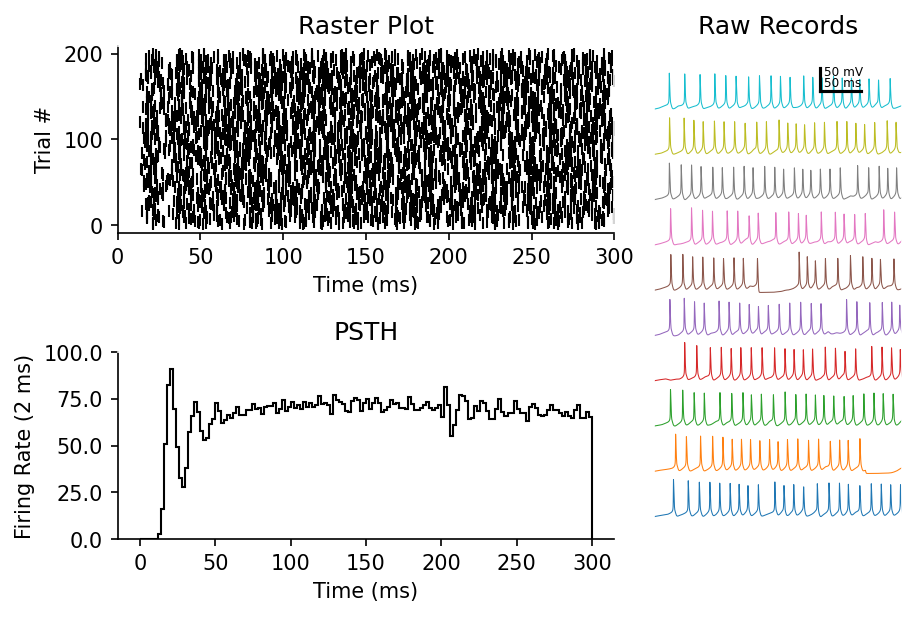

In [8]:
#This optional module produces some immediate visualization of the model run, including a raster, PSTH and sample traces.

random_trials = np.random.choice(np.arange(num_trials),10, replace = False)

raster_index_value = (position_raster < 200).sum()

if num_trials == 200:
    tick_labels = np.array([0,10, 20, 30, 40, 50])/num_trials * 500
elif num_trials == 5000:
    tick_labels = np.array([0, 250, 500, 750, 1000])/num_trials * 500

fig = plt.figure(dpi = 150, constrained_layout = True)

mosaic = """
    AAC
    BBC
    """
ax_dict = fig.subplot_mosaic(mosaic)
ax_dict['A'].plot(spike_times_all[0:raster_index_value],position_raster[0:raster_index_value], '|', color = 'black', linewidth = 0.5)
ax_dict['A'].set_ylabel('Trial #')
ax_dict['A'].set_xlabel("Time (ms)")
ax_dict['A'].set_title('Raster Plot')
ax_dict['A'].set_xlim(0,300)

ax_dict['B'].hist(spike_times_all,bins = np.linspace(0,300,151), color = 'black', histtype = 'step')
if num_trials == 5000: ax_dict['B'].set_yticks(np.array([0, 250, 500, 750, 1000], dtype = 'int'))
elif num_trials == 200: ax_dict['B'].set_yticks(np.array([0, 10, 20, 30, 40, 50], dtype = 'int'))
ax_dict['B'].set_title('PSTH')
ax_dict['B'].set_xlabel("Time (ms)")
ax_dict['B'].set_ylabel('Firing Rate (2 ms)')
ax_dict['B'].set_yticklabels(tick_labels)

for i in range(len(random_trials)):
    ax_dict['C'].plot(t[random_trials[i]], mem_pot[random_trials[i]]+(i*100), linewidth = 0.5)
    ax_dict['C'].set_xlim(0,300)
    ax_dict['C'].set_title('Raw Records')
ax_dict['C'].plot([200,250], [875,875], color = 'black')
ax_dict['C'].plot([200,200],[875,925], color = 'black')
ax_dict['C'].text(205,885,'50 ms', fontsize = 'xx-small')
ax_dict['C'].text(205,910,'50 mV', fontsize = 'xx-small')
ax_dict['C'].set_yticks([])
ax_dict['C'].set_xticks([])
ax_dict['C'].spines['bottom'].set_color('white')
ax_dict['C'].spines['top'].set_color('white')
ax_dict['C'].spines['right'].set_color('white')
ax_dict['C'].spines['left'].set_color('white')

ax_dict['A'].spines['top'].set_color('white')
ax_dict['A'].spines['right'].set_color('white')
ax_dict['B'].spines['top'].set_color('white')
ax_dict['B'].spines['right'].set_color('white')

plt.savefig('PF_Burst_2pf.tiff')
plt.show()

In [9]:
#Module to save spike times as a pickle file to run later analysis on. Change run_name to approrpriate descriptive name
run_name = 'E_I_welltimed_3pf_halfMLI'

outfile = open(run_name, 'wb')
pickle.dump(spike_times_all,outfile)
outfile.close()

